# Sevendi Eldrige Rifki Poluan🔥🔥🔥
### Descriptions: Time series prediction

In [2]:
# working environment
!nvidia-smi

Wed May 17 13:26:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   44C    P0   116W / 390W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pandas_ta
!pip install mplfinance
!pip install plotly
!pip install pydot

In [ ]:
!apt-get install graphviz -y

## <font color='red'>Import the necessary libraries</font>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os  
import time 
import datetime
import matplotlib.pyplot as plt
import pandas_ta as ta # https://github.com/twopirllc/pandas-ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.graph_objects as go

2023-05-17 13:39:58.763524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [58]:
tf.__version__

'2.12.0'

## <font color='red'>For this experiment, I will be conducting basic time series forecasting on EUR_USD data from the forex market, covering the period from 2005 to 2020. The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/imetomi/eur-usd-forex-pair-historical-data-2002-2019?resource=download), where you can also access and download the dataset.</font>

In [494]:
!ls

FOREX_EUR_USD_prediction.ipynb	archive.zip  eurusd_hour.csv	eurusd_news.csv
README.md			checkpoint   eurusd_minute.csv	model.png


In [4]:
!unzip -o archive.zip

Archive:  archive.zip
  inflating: eurusd_hour.csv         
  inflating: eurusd_minute.csv       
  inflating: eurusd_news.csv         


In [5]:
!ls

FOREX_EUR_USD_prediction.ipynb	eurusd_hour.csv    eurusd_news.csv
archive.zip			eurusd_minute.csv


## <font color='red'>Let's load the dataset for one-hour data prediction.</font>

In [6]:
datasets_hour = pd.read_csv("eurusd_hour.csv")

In [7]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003


In [8]:
datasets_hour.shape

(93084, 12)

In [9]:
max(datasets_hour.Date), min(datasets_hour.Date)

('2020-04-29', '2005-05-02')

## <font color='red'>In this scenario, since the dataset includes both ask and bid prices, I will only consider using the bid price data, assuming it represents the market price data in the dataset.</font> 

In [10]:
datasets_hour = datasets_hour[["Date", "Time", "BO", "BH", "BL", "BC"]] 

In [11]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855


## <font color='red'>I want to try a different approach for predicting the market data. Instead of directly predicting the next market price, I will predict the value of how many pips the market will move from the current price.</font>

In [12]:
datasets_hour["Target"] = datasets_hour.BC.diff()

In [13]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC,Target
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,NaN
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,-0.0002
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0009
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0000
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.0004


In [14]:
datasets_hour["Target"].head()

0       NaN
1   -0.0002
2    0.0009
3    0.0000
4    0.0004
Name: Target, dtype: float64

In [15]:
datasets_hour["Target"] = datasets_hour["Target"].shift(-1)

In [16]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC,Target
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,-0.0002
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,0.0009
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0000
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0004
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,-0.0001


## <font color='red'>Given that our target price scale is very small, I intend to scale up the values to a larger magnitude. This approach aims to prevent mispredictions by the model and improve its learning efficiency.</font>

In [17]:
label_scale = MinMaxScaler()
label_scale.fit(np.expand_dims(datasets_hour.Target, axis=1))
datasets_hour["Target"] = label_scale.transform(np.expand_dims(datasets_hour.Target, axis=1))
datasets_hour["Target"]

0        0.449638
1        0.469565
2        0.453261
3        0.460507
4        0.451449
           ...   
93079    0.459601
93080    0.446014
93081    0.454348
93082    0.458514
93083         NaN
Name: Target, Length: 93084, dtype: float64

## <font color='red'>Given that time series data, such as forex market data, can exhibit seasonal patterns, I have decided to incorporate both date and hour information as training data. To encode these time units in a cyclical manner, I will use Periodicity encoding techniques, such as sine and cosine functions, to represent the cyclical patterns of date and hour information in a continuous and periodic manner.</font>

    Periodicity encoding is a technique used in machine learning to represent time units, such as hours, days, months, or seasons, as periodic features using trigonometric functions, typically sine and cosine. This encoding allows the model to capture periodic patterns in the data more accurately, as it accounts for the cyclical nature of time units.

    The basic idea behind periodicity encoding is to map time units onto a continuous scale that represents their cyclical patterns. For example, in a 24-hour time format, the hours repeat in a cyclical pattern from 0 to 23. By using sine and cosine functions, which have periodic properties with values ranging from -1 to 1, we can map the time units onto this continuous scale in a way that captures their cyclical patterns.

    By encoding time units as periodic features, the model can learn to capture the cyclical patterns in the data more effectively. For example, in time series forecasting tasks, where the data exhibits periodic patterns such as daily or seasonal trends, periodicity encoding can help the model better understand and utilize these patterns in its predictions.

In [18]:
datasets_hour["month_sin"] = datasets_hour.Date.apply(lambda x: np.sin(2 * np.pi * int(x.split("-")[1]) / 12))
datasets_hour["month_cos"] = datasets_hour.Date.apply(lambda x: np.cos(2 * np.pi * int(x.split("-")[1]) / 12))

datasets_hour["date_sin"] = datasets_hour.Date.apply(lambda x: np.sin(2 * np.pi * int(x.split("-")[2]) / 31))
datasets_hour["date_cos"] = datasets_hour.Date.apply(lambda x: np.cos(2 * np.pi * int(x.split("-")[2]) / 31))

datasets_hour["hour_sin"] = datasets_hour.Time.apply(lambda x: np.sin(2 * np.pi * int(x.split(":")[0]) / 12))
datasets_hour["hour_cos"] = datasets_hour.Time.apply(lambda x: np.cos(2 * np.pi * int(x.split(":")[0]) / 12)) 

In [19]:
datasets_hour.head()

,Date,Time,BO,BH,BL,BC,Target,month_sin,month_cos,date_sin,date_cos,hour_sin,hour_cos
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,0.449638,0.5,-0.866025,0.394356,0.918958,0.000000,1.000000e+00
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,0.469565,0.5,-0.866025,0.394356,0.918958,0.500000,8.660254e-01
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.453261,0.5,-0.866025,0.394356,0.918958,0.866025,5.000000e-01
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.460507,0.5,-0.866025,0.394356,0.918958,1.000000,6.123234e-17
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.451449,0.5,-0.866025,0.394356,0.918958,0.866025,-5.000000e-01


## <font color='red'>I will exclude the "Date" and "Time" columns from the dataset.</font>

In [20]:
datasets_hour = datasets_hour[datasets_hour.columns[2:]]

In [21]:
datasets_hour.head()

,BO,BH,BL,BC,Target,month_sin,month_cos,date_sin,date_cos,hour_sin,hour_cos
0,1.2852,1.2852,1.2840,1.2844,0.449638,0.5,-0.866025,0.394356,0.918958,0.000000,1.000000e+00
1,1.2844,1.2848,1.2839,1.2842,0.469565,0.5,-0.866025,0.394356,0.918958,0.500000,8.660254e-01
2,1.2843,1.2854,1.2841,1.2851,0.453261,0.5,-0.866025,0.394356,0.918958,0.866025,5.000000e-01
3,1.2851,1.2859,1.2850,1.2851,0.460507,0.5,-0.866025,0.394356,0.918958,1.000000,6.123234e-17
4,1.2852,1.2859,1.2849,1.2855,0.451449,0.5,-0.866025,0.394356,0.918958,0.866025,-5.000000e-01


## <font color='red'>Additionally, I would like to incorporate technical analysis data such as RSI (Relative Strength Index), EMA (Exponential Moving Average), etc. into our dataset.</font>

In [22]:
datasets_hour['rsi'] = ta.rsi(datasets_hour.BC, length=20)
datasets_hour['ema20'] = ta.ema(datasets_hour.BC, length=20)
datasets_hour['ema100'] = ta.ema(datasets_hour.BC, length=100)
datasets_hour['ema50'] = ta.ema(datasets_hour.BC, length=50)
datasets_hour['ema200'] = ta.ema(datasets_hour.BC, length=200)
datasets_hour['willr'] = ta.willr(datasets_hour.BH, datasets_hour.BL, datasets_hour.BC, length=20)
datasets_hour = pd.concat([datasets_hour, ta.stochrsi(datasets_hour.BC, length=50, rsi_length=20)], axis=1)
datasets_hour = pd.concat([datasets_hour, ta.bbands(datasets_hour.BH, length=20)], axis=1)              

In [23]:
datasets_hour.head()

,BO,BH,BL,BC,Target,month_sin,month_cos,date_sin,date_cos,hour_sin,...,ema50,ema200,willr,STOCHRSIk_50_20_3_3,STOCHRSId_50_20_3_3,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,1.2852,1.2852,1.2840,1.2844,0.449638,0.5,-0.866025,0.394356,0.918958,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.2844,1.2848,1.2839,1.2842,0.469565,0.5,-0.866025,0.394356,0.918958,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.2843,1.2854,1.2841,1.2851,0.453261,0.5,-0.866025,0.394356,0.918958,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2851,1.2859,1.2850,1.2851,0.460507,0.5,-0.866025,0.394356,0.918958,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.2852,1.2859,1.2849,1.2855,0.451449,0.5,-0.866025,0.394356,0.918958,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <font color='red'>As we have added some technical analysis features, such as exponential moving average (EMA), RSI, etc., to our dataset, the first few data points in the dataset will be null due to the computation of these technical analysis indicators. Therefore, I will need to drop these rows from our dataset.</font>

In [24]:
datasets_hour.dropna(inplace=True)

In [25]:
datasets_hour.head()

,BO,BH,BL,BC,Target,month_sin,month_cos,date_sin,date_cos,hour_sin,...,ema50,ema200,willr,STOCHRSIk_50_20_3_3,STOCHRSId_50_20_3_3,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
199,1.27570,1.27665,1.27420,1.27640,0.462319,0.5,-0.866025,0.651372,-0.758758,-0.500000,...,1.282787,1.287511,-84.561404,10.640978,16.742963,1.276901,1.281176,1.285450,0.667210,-0.029414
200,1.27630,1.27690,1.27530,1.27690,0.452355,0.5,-0.866025,0.651372,-0.758758,-0.866025,...,1.282556,1.287405,-70.747562,9.948728,11.517715,1.277435,1.280598,1.283761,0.494022,-0.084531
201,1.27690,1.27760,1.27650,1.27685,0.463225,0.5,-0.866025,0.651372,-0.758758,-1.000000,...,1.282333,1.287300,-71.289274,15.747383,12.112363,1.277015,1.280431,1.283846,0.533513,0.085655
202,1.27685,1.27760,1.27665,1.27740,0.443297,0.5,-0.866025,0.651372,-0.758758,-0.866025,...,1.282139,1.287202,-65.330444,19.658201,15.118104,1.276652,1.280224,1.283796,0.558058,0.132719
203,1.27740,1.27760,1.27630,1.27685,0.351449,0.5,-0.866025,0.651372,-0.758758,-0.500000,...,1.281932,1.287099,-71.289274,20.368496,18.591360,1.276387,1.279983,1.283578,0.561880,0.168727


## <font color='red'>Next, we will define the sequence and label for the prediction.</font>

    In this approach, I will use a shortcut to map the dataset into a sequence array of IDs. This helps to minimize the time and memory required for formulating the dataset into a sequence from scratch, making the process more efficient.

In [26]:
SEQ = 10 # total sequence
TARGET_NEXT = 1 # next 1/2/3 hour(s)
dt_length = datasets_hour.shape[0] # total datasets
TOTAL_DATASETS_TO_USE = (dt_length - (dt_length % (SEQ + 1))) - SEQ
CHANNEL = datasets_hour.shape[1]

In [27]:
SEQ, TARGET_NEXT, dt_length, TOTAL_DATASETS_TO_USE, CHANNEL

(10, 1, 92884, 92874, 24)

In [28]:
IDS = np.expand_dims(np.arange(0, TOTAL_DATASETS_TO_USE, SEQ), axis=1) + np.arange(0, SEQ + TARGET_NEXT)
IDS

array([[    0,     1,     2, ...,     8,     9,    10],
       [   10,    11,    12, ...,    18,    19,    20],
       [   20,    21,    22, ...,    28,    29,    30],
       ...,
       [92850, 92851, 92852, ..., 92858, 92859, 92860],
       [92860, 92861, 92862, ..., 92868, 92869, 92870],
       [92870, 92871, 92872, ..., 92878, 92879, 92880]])

In [29]:
INP_IDS = IDS[:, :-TARGET_NEXT]
INP_IDS

array([[    0,     1,     2, ...,     7,     8,     9],
       [   10,    11,    12, ...,    17,    18,    19],
       [   20,    21,    22, ...,    27,    28,    29],
       ...,
       [92850, 92851, 92852, ..., 92857, 92858, 92859],
       [92860, 92861, 92862, ..., 92867, 92868, 92869],
       [92870, 92871, 92872, ..., 92877, 92878, 92879]])

In [30]:
LBL_IDS = IDS[:, -1:]
LBL_IDS

array([[   10],
       [   20],
       [   30],
       ...,
       [92860],
       [92870],
       [92880]])

## <font color='red'>Now we can use the ID sequence to map the dataset, separating it into input and label components.</font>
    
       In this scenario, I will attempt to predict the close prices.

In [31]:
X = np.array(datasets_hour)[INP_IDS]
Y = np.array(datasets_hour[["Target"]])[LBL_IDS].flatten() # predict labels 

In [32]:
X.shape, Y.shape

((9288, 10, 24), (9288,))

## <font color='red'>We will normalize the values of our datasets to create a more generalized data for our model to learn from. This normalization process will also assist the model in making predictions that are more generalized, as it helps to scale the data to a consistent range.</font>

In [33]:
standard_scaler = StandardScaler()
standard_scaler.fit(np.reshape(X, (X.shape[0], -1)))
X = np.reshape(standard_scaler.transform(np.reshape(X, (X.shape[0], -1))), X.shape)

In [34]:
X[:1]

array([[[ 7.88718692e-02,  7.82376105e-02,  7.49411770e-02,
          8.43997720e-02,  3.05199040e-01,  7.16510266e-01,
         -1.21581693e+00,  9.11132984e-01, -1.05091860e+00,
         -7.08058769e-01, -1.22305749e+00, -1.36279068e+00,
          1.14585288e-01,  1.47439275e-01,  1.34248253e-01,
          1.70785606e-01, -1.18035483e+00, -1.34064169e+00,
         -1.15214607e+00,  1.16451213e-01,  1.13480665e-01,
          1.10469006e-01, -9.61923414e-02, -1.52609213e+00],
        [ 8.35797208e-02,  8.00433257e-02,  8.37715657e-02,
          8.82766568e-02, -4.85427943e-02,  7.16564426e-01,
         -1.21590575e+00,  9.11100380e-01, -1.05098742e+00,
         -1.22504163e+00, -7.05566076e-01, -1.21598460e+00,
          1.12082876e-01,  1.46270501e-01,  1.32448412e-01,
          1.69967118e-01, -7.10263729e-01, -1.36348047e+00,
         -1.33120521e+00,  1.20639025e-01,  1.08953994e-01,
          9.73328596e-02, -4.28889488e-01, -1.69545838e+00],
        [ 8.82425619e-02,  8.54536275e

## <font color='red'>Now we can proceed to split our dataset into training and testing subsets.</font>

    Since this is time series data, we won't shuffle the data during the splitting process. Instead, we'll split the data based on a given percentage, taking data from the last point in the dataset up to the specified percentage.

In [35]:
PERCENTAGE = 0.2

In [36]:
np.var(Y), np.std(Y)

(0.000854045220518029, 0.029224052089298447)

In [37]:
max(Y), min(Y)

(0.7599637681159439, 0.11811594202898623)

In [38]:
x_train, y_train = X[:-int(X.shape[0] * PERCENTAGE)], Y[:-int(X.shape[0] * PERCENTAGE)] 
x_test, y_test = X[-int(X.shape[0] * PERCENTAGE):], Y[-int(X.shape[0] * PERCENTAGE):]

In [39]:
y_train

array([0.45326087, 0.4442029 , 0.48913043, ..., 0.44692029, 0.45833333,
       0.44492754])

In [40]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7431, 10, 24), (7431,), (1857, 10, 24), (1857,))

In [41]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) 

2023-05-17 13:40:51.406445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22244 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


## <font color='red'>I will now proceed to construct our model for training.</font>

    For our model architecture, I will be using a simple transformer model that incorporates the MultiHeadAttention layer. The MultiHeadAttention layer is a key component of the transformer model, which allows the model to attend to different parts of the input sequence with multiple heads, or attention mechanisms, in parallel. This allows the model to capture complex dependencies and relationships within the input data, making it well-suited for tasks such as sequence prediction and language modeling.

In [42]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [141]:
def simple_transformer_model(id, x):
    normalized = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"normalized_1_{id}")(x)
    masked_output = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128, name=f"attention_{id}")(normalized, normalized)  
    x = tf.keras.layers.Add(name=f"add_{id}")([x, masked_output]) 
    x = tf.keras.layers.Conv1D(256, 1, activation='relu', name=f"first_conv_{id}")(x)  
    return x

In [142]:
def create_model(num_transformer_blocks=1):
    inputs = tf.keras.layers.Input(shape=(SEQ, CHANNEL)) 
    x = inputs
    for _ in range(num_transformer_blocks):
        x = simple_transformer_model(_, x) 
    
    x = tf.keras.layers.Dense(256, activation="tanh")(x)
    x = tf.keras.layers.Dense(512, activation="tanh")(x) 
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="mse", 
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mse"])
    
    return model

In [143]:
model = create_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 10, 24)]     0           []                               
                                                                                                  
 normalized_1_0 (LayerNormaliza  (None, 10, 24)      48          ['input_9[0][0]']                
 tion)                                                                                            
                                                                                                  
 attention_0 (MultiHeadAttentio  (None, 10, 24)      25368       ['normalized_1_0[0][0]',         
 n)                                                               'normalized_1_0[0][0]']         
                                                                                            

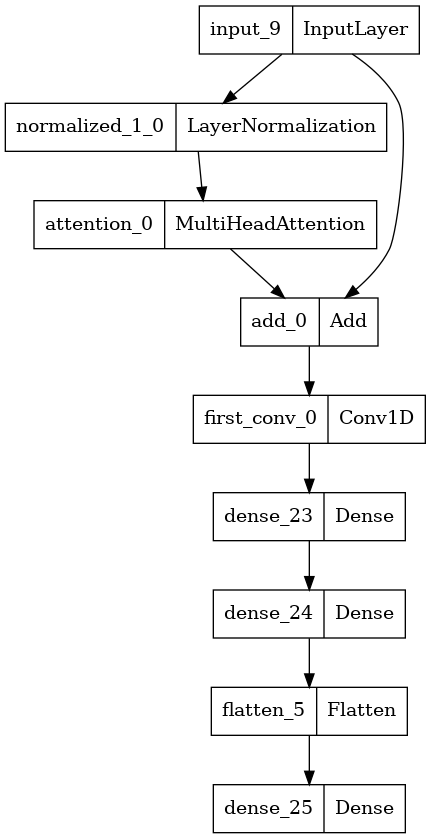

In [144]:
tf.keras.utils.plot_model(model)

## <font color='red'>We will define callbacks for updating the learning rate, implementing early stopping if the model does not show improvement, and saving the model whenever there is a decrease in the training loss.</font>

In [145]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, factor, patience, min_lr):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        
        # print('\rlr_logs: ', logs, '\r')
        # print("\rwait: ", self.wait, "\r")
        # print("\rCurrent lr:", tf.keras.backend.get_value(self.model.optimizer.lr), "\r")
        
        current_val_loss = logs['val_loss'] 
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            # print("\rself.wait >= self.patience:", self.wait >= self.patience, "\r")
            if self.wait >= self.patience:
                old_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
                new_lr = old_lr * self.factor
                
                # print("\rnew_lr >= self.min_lr:", new_lr >= self.min_lr, "\r")
                if new_lr >= self.min_lr:
                    # print(f'\rEpoch {epoch+1}: Learning rate reduced to {new_lr} \r')
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                else:
                    # print(f'\rEpoch {epoch+1}: Minimum learning rate reached\r')
                    pass
                self.wait = 0
                
lr_callback = CustomLearningRateScheduler(factor=0.1, 
                                          patience=5,
                                          min_lr=1e-7) 

In [146]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=20, # Number of epochs with no improvement after which training will be stopped.
                                               start_from_epoch=1,
                                               mode="min") # training will stop when the quantity monitored has stopped decreasing

In [147]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        # print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
        
        # print('\rcurrent_val_loss: ', current_val_loss, '\r')
        # print('\rsave_best_only: ', self.save_best_only, '\r')
        # print('\rbest_val_loss: ', self.best_val_loss, '\r')
        # print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            # print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            # print("\rModel has been saved!")
        else:
            # print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            # print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='checkpoint/save-model/', save_best_only=True)

## <font color='red'>Now, it is time to commence the training process of our model.</font>

In [148]:
BATCH_SIZE = 100

train = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [149]:
len(train) * SEQ, len(test) * SEQ

(750, 190)

In [150]:
for x in train:
    print(x[0].shape, x[1].shape)
    break

(100, 10, 24) (100,)


2023-05-17 13:53:15.064810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7431]
	 [[{{node Placeholder/_1}}]]
2023-05-17 13:53:15.072267: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [151]:
history = model.fit(train, epochs=50, verbose=1, validation_data=test, validation_steps=len(test) * 0.25, callbacks=[save_callbacks, es_callback, lr_callback])

Epoch 1/50
74/75 [============================>.] - ETA: 0s - loss: 0.2395 - mse: 0.2395

2023-05-17 13:53:17.798930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1857]
	 [[{{node Placeholder/_1}}]]


75/75 [==============================] - 3s 18ms/step - loss: 0.2385 - mse: 0.2385 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 2/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 5/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 8/50
75/75 [==============================] - 1s 12ms/step - loss: 0.0015 - mse: 0.0015 

In [152]:
model.evaluate(test)

19/19 [==============================] - 0s 6ms/step - loss: 6.6797e-04 - mse: 6.6797e-04


[0.0006679650396108627, 0.0006679650396108627]

## <font color='red'>Evaluation of model performance.</font>

In [153]:
np.array(history.history['loss']).shape

(50,)

<Axes: >

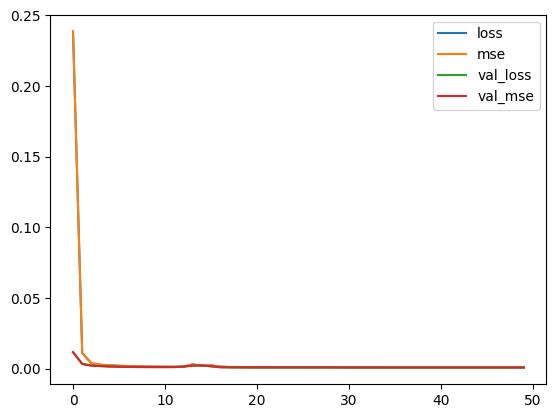

In [154]:
pd.DataFrame(history.history).plot()

## <font color='red'>Since only the weights of our model are saved during training, we need to define the model architecture before loading the saved weights.</font>

In [155]:
load_model = create_model()  
load_model.load_weights("checkpoint/save-model/")

## <font color='red'>Now, let's assess the performance of our model using the testing data.</font>

In [156]:
performance = load_model.evaluate(test)
print("MSE:", performance[1])

19/19 [==============================] - 0s 5ms/step - loss: 6.6797e-04 - mse: 6.6797e-04
MSE: 0.0006679650396108627


In [157]:
y_pred = load_model.predict(test)
print(y_pred[:20], y_train[:20])

19/19 [==============================] - 0s 4ms/step
[[0.44567236]
 [0.47838932]
 [0.44503623]
 [0.43341675]
 [0.420125  ]
 [0.45259196]
 [0.42225313]
 [0.46612683]
 [0.4582906 ]
 [0.45179087]
 [0.4620697 ]
 [0.4496905 ]
 [0.4577187 ]
 [0.46542302]
 [0.43208236]
 [0.48715088]
 [0.45678312]
 [0.4774578 ]
 [0.48801026]
 [0.4539621 ]] [0.45326087 0.4442029  0.48913043 0.46322464 0.43423913 0.46231884
 0.44148551 0.45380435 0.4548913  0.49764493 0.45416667 0.43876812
 0.45869565 0.44057971 0.4384058  0.46594203 0.4423913  0.44257246
 0.48677536 0.4384058 ]


## <font color='red'>In order to visualize the performance of our model in predicting the testing time series data, let's plot them all.</font>

    "We need to inverse the prediction values back to their original scale because during training, the values were normalized."
    
    "After inverting the prediction values back to their original scale, we also need to add them to the input closing values to obtain the actual predicted future price values."

In [158]:
x_test_transform = np.reshape(standard_scaler.inverse_transform(np.reshape(x_test, (x_test.shape[0], -1))), x_test.shape)[:, :, :]
results = pd.DataFrame()

In [159]:
results["Open"] = x_test_transform[:, -1, 0].flatten()
results["High"] = x_test_transform[:, -1, 1].flatten()
results["Low"] = x_test_transform[:, -1, 2].flatten()
results["Close"] = x_test_transform[:, -1, 3].flatten()
results["y_test"] = label_scale.inverse_transform(np.expand_dims(y_test, axis=1)).flatten()
results["y_target"] = results["Close"] + results["y_test"]
results["y_pred"] = results["Close"] + label_scale.inverse_transform(y_pred).flatten()

In [160]:
results.head()

,Open,High,Low,Close,y_test,y_target,y_pred
0,1.08846,1.09013,1.08828,1.09012,0.00007,1.09019,1.089701
1,1.09011,1.09030,1.08927,1.08942,-0.00014,1.08928,1.090807
2,1.08925,1.08929,1.08896,1.08902,0.00001,1.08903,1.088566
3,1.09086,1.09233,1.09085,1.09141,-0.00074,1.09067,1.090315
4,1.09082,1.09121,1.09038,1.09064,0.00033,1.09097,1.088811


## <font color='red'>This plot displays the graph of our prediction data in comparison to the target closing price of the next candle's closing price. It helps us visualize the accuracy of our predictions and how well they align with the actual closing price of the next candle.</font>
 
     Please note that this plot only shows the predicted price of the top sequence in relation to its next candle's closing price.

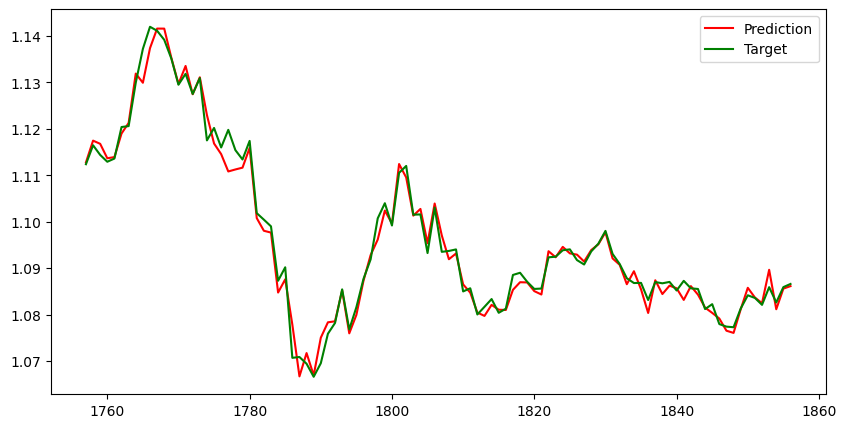

In [161]:
ROW_TO_SHOW = 100
plt.figure(figsize=(10, 5))
plt.plot(results["y_pred"][-ROW_TO_SHOW:], c='red')
plt.plot(results["y_target"][-ROW_TO_SHOW:], c='green')
plt.legend(["Prediction", "Target"])

## <font color='red'>In real market prediction, it's important to determine if our model is making accurate predictions by checking if our predicted price falls within the range of the highest and lowest price of the next candle. Let's visualize this comparison to gain insights.</font>

    Please note that this plot only shows the predicted price of the top sequence in relation to its next candle's closing price.
   

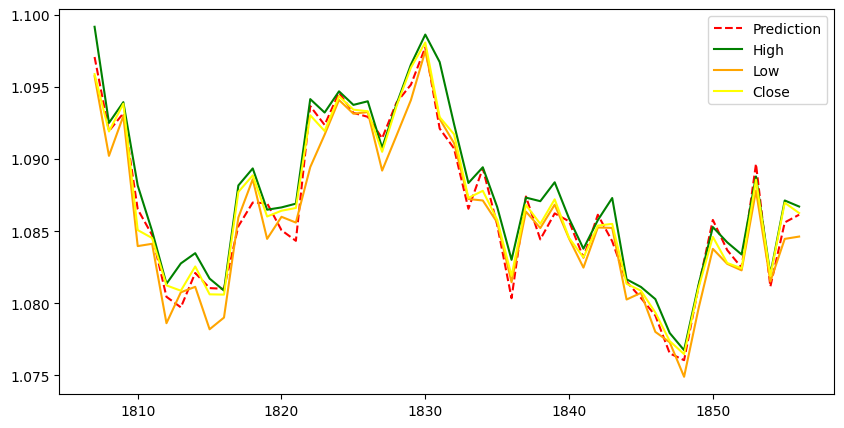

In [162]:
ROW_TO_SHOW = 50
plt.figure(figsize=(10, 5))
plt.plot(results["y_pred"][-ROW_TO_SHOW:], c='red', linestyle="--")
plt.plot(results["High"][-ROW_TO_SHOW:], c='Green')
plt.plot(results["Low"][-ROW_TO_SHOW:], c='Orange')
plt.plot(results["Close"][-ROW_TO_SHOW:], c='yellow')
plt.legend(["Prediction", "High", "Low", "Close"])

## <font color='red'>What if we plot the prediction values in a candlestick form? Since there may be a large amount of data, which could potentially consume a significant amount of memory, we could choose to plot only a subset of the data for visualization purposes.</font>
 
     "It's important to note that when visualizing the prediction values in a candlestick chart, I only plot the value at the last index of the sequence. As a result, there may be around (SEQ - 1) candlesticks that are not plotted, since they represent previous data points in the sequence."
     
     "But, we cannot see the next candle, which represents future price predictions. Therefore, we won't know if our price prediction will be accurate or not."

In [183]:
fig = go.Figure()
fig.add_trace(go.Candlestick( 
                open=x_test_transform[:, -1, 0].flatten()[-20:],
                high=x_test_transform[:, -1, 1].flatten()[-20:],
                low=x_test_transform[:, -1, 2].flatten()[-20:],
                close=x_test_transform[:, -1, 3].flatten()[-20:])) 
fig.add_trace(go.Scatter(
                y=x_test_transform[:, -1, 3].flatten()[-20:],
                mode='markers',
                marker=dict(symbol='circle', size=5),   
                name='Last closing price'))

fig.add_trace(go.Scatter(
                y=results["y_pred"][-20:],
                mode='markers',
                marker=dict(symbol='circle', size=5),   
                name='Prediction price')) 

# <font color='blue'>There is no guaranteed way to predict the market accurately, whether through fundamental analysis, technical analysis, or even machine learning approaches. This project is solely for learning purposes and aims to explore time series data prediction. Regardless, I hope you have gained valuable insights from this project.</font>